In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time # delay within program
from math import *
import random
import pickle
import os
import json

import nidaqmx # laser output
from pyueye import ueye
from pypyueye import Camera

from improc import *
from worm_env import *

# Initial checks

In [10]:
cam.exit()

In [2]:
templates,bodies = load_templates()
cam,task = init_instruments()

In [3]:
bgs = make_vec_bg(cam,task,[0,1],total_time=10)

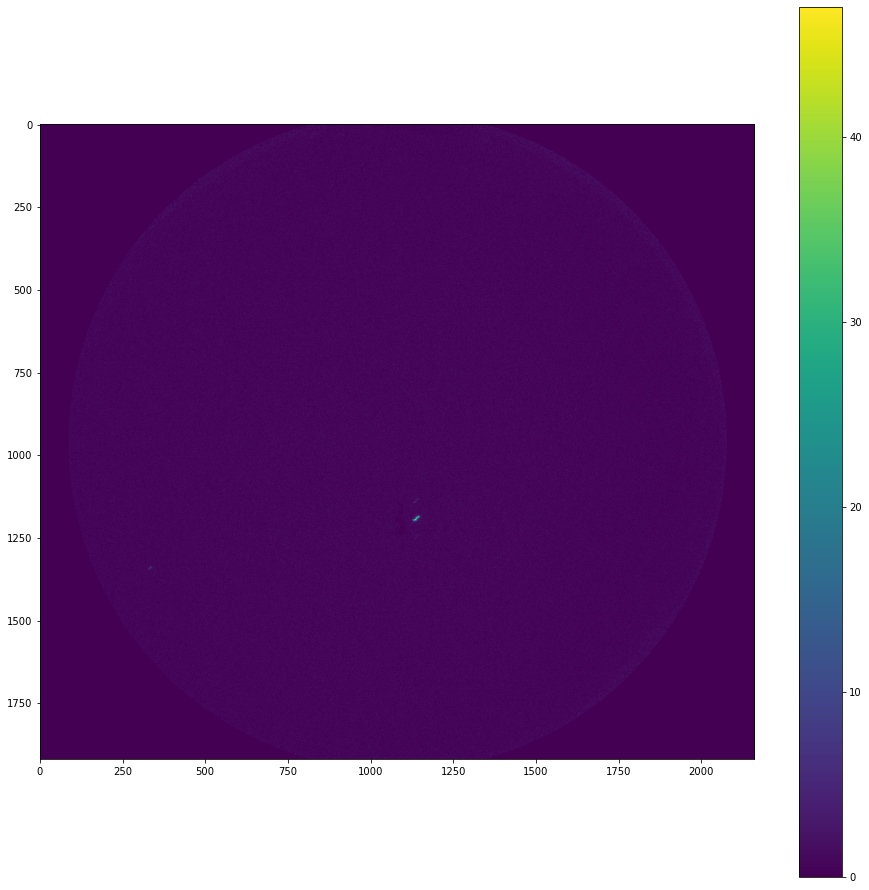

In [4]:
# Check that things are working
plt.figure(figsize=(16,16))
img = grab_im(cam,bgs[0])
plt.imshow(img)
plt.colorbar();

[{'loc': array([1136.39759036, 1192.14457831]), 'img': array([[0, 2, 2, ..., 2, 1, 1],
       [0, 2, 0, ..., 0, 0, 1],
       [0, 2, 1, ..., 1, 0, 0],
       ...,
       [0, 1, 3, ..., 0, 0, 3],
       [0, 0, 0, ..., 0, 0, 1],
       [3, 0, 0, ..., 0, 0, 1]], dtype=uint8), 'scores': array([128412, 186210]), 'angs': array([180,  60]), 'endpts': array([[1127, 1144],
       [1197, 1185]]), 'body': 240}]


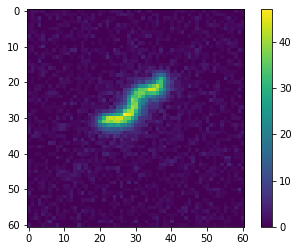

In [5]:
worms = find_worms(img,templates,bodies)
print(worms)
plt.imshow(worms[0]['img'])
plt.colorbar();

In [6]:
track,angs,lights = if_stmt_angle(90,cam,task,bgs,templates,bodies,total_time=60)

Finding orientation
elapsed 2

1
	 1126.37 -1184.2
	body 120 head 150 light 0
2
	 1128.16 -1184.19
	body 240 head 90 light 1
3
	 1132.89 -1183.79
	body 240 head 180 light 1
5
	 1136.3 -1183.04
	body 150 head 270 light 0
6
	 1139.58 -1182.96
	body 150 head 210 light 0
7
	 1144.74 -1184.11
	body 330 head 60 light 1
9
	 1148.67 -1184.22
	body 330 head 0 light 1
10
	 1153.59 -1184.13
	body 30 head 0 light 0
11
	 1157.21 -1183.27
	body 30 head 0 light 0
12
	 1161.15 -1182.53
	body 30 head 300 light 0
14
	 1166.11 -1182.24
	body 330 head 60 light 1
15
	 1172.12 -1181.05
	body 30 head 0 light 0
16
	 1176.74 -1180.14
	body 30 head 60 light 1
18
	 1181.56 -1177.33
	body 30 head 30 light 0
19
	 1185.07 -1173.88
	body 60 head 90 light 1
20
	 1187.09 -1169.01
	body 60 head 90 light 1
22
	 1188.21 -1163.91
	body 120 head 60 light 1
23
	 1188.61 -1158.72
	body 60 head 120 light 1
24
	 1189.04 -1155.04
	body 60 head 90 light 1
25
	 1189.58 -1151.57
	body 60 head 150 light 1
27
	 1189.01 -1146.33
	bod

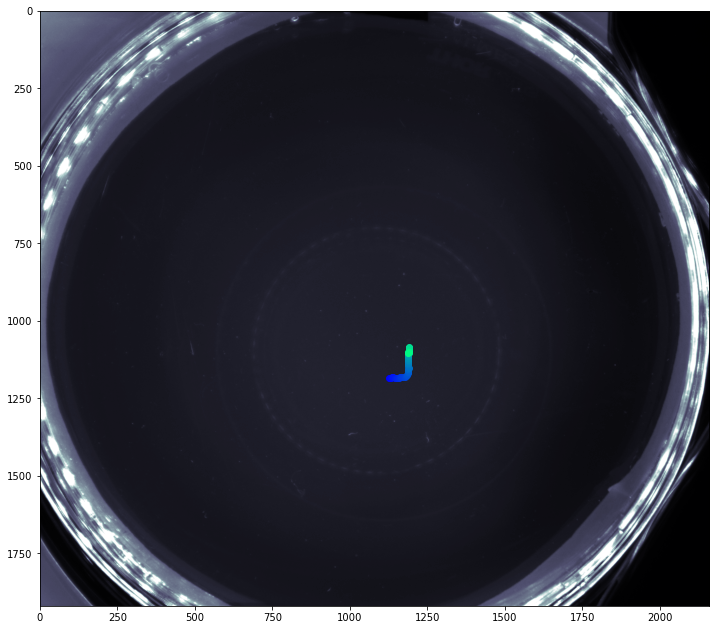

In [7]:
fig,ax = plt.subplots(1)
img = grab_im(cam,None)
ax.imshow(img,cmap='bone')
fig.set_size_inches((12,12))
NPOINTS = track.shape[0]
ax.set_prop_cycle('color',plt.cm.winter(np.linspace(0,1,NPOINTS)))
for i in range(NPOINTS-1):
    ax.scatter(track[i,1],track[i,2])
    ax.set_aspect('equal','box')

# Benchmarking. 
This includes deterministic policy and simple averaging.

## Random actions
#### Program flow:
* Initializes environment.
* Collects background and sets target angle
* Runs 8 episodes for 5 minutes (300 s) each:
    * While episode is going:
        * Randomly picks action
        * Takes one step
        * Adds results to a trajectory dictionary
    * Prints number of steps taken during episode
    * Saves entire trajectory to .json file as dictionary
* Closes environment.

In [2]:
# Save track, total reward history, observations, endpoints, images, action history
fbase = 'Data/Random_i0_'
env = ProcessedWorm(0,ep_len=300)
eps_per_worm = 8

WORM_NUMBER = 0


for i_episode in np.arange(eps_per_worm)+WORM_NUMBER*eps_per_worm:
    done = False
    fname = fbase+str(i_episode)+'.json'
    trajectory = {}
    
    obs = env.reset(target=(i_episode*90)%360)
    
    while not done:
        action = env.action_space.sample()
        obs, r, done, info = env.step(action)
        print(f'Body and head: {obs} \t\t\r',end='')
        
        # Combining trajectory data in info with previous steps
        add_to_traj(trajectory,info)
        
    print("Episode finished after {} timesteps".format(info['t']))
    
    with open(fname,'wb') as f:
        json.dump(trajectory,f)
    
env.close()

Episode finished after 201 timesteps
Episode finished after 201 timesteps


## Deterministic policy
Same flow as random action above but picks actions according to known AIY policy.

In [2]:
def det_policy(obs):
    # Returns 0 if obs is nans.
    # Otherwise, returns the known deterministic policy.
    if np.isnan(obs[0]):
        return 0
    body_dir,head_body = obs
    if body_dir*head_body < 0:
        action = 1
    elif body_dir == 0:
        if head_body == 0:
            action = 1
        else:
            action = 0
    else:
        action = 0
    return action

In [4]:
env.close()

In [ ]:
fbase = 'Data/Known_i0_'
env = ProcessedWorm(0,ep_len=300)
eps_per_worm = 8

curr_ep = 1
WORM_NUMBER = 0


for i_episode in np.arange(eps_per_worm-curr_ep)+curr_ep+WORM_NUMBER*eps_per_worm:
    done = False
    fname = fbase+str(i_episode)+'.npz'
    trajectory = {}
    action = 0
    
    obs = env.reset(target=0) #target=(i_episode*90)%360)
    
    while not done:
        obs, r, done, info = env.step(action)
        print('{}:\t {}\t r:{}\t\t\r'.format(int(info['t']),
                                             obs,round(r,2)),end='')
        
        # Combining trajectory data in info with previous steps
        add_to_traj(trajectory,info)
        
        # Chooses action for next step
        action = det_policy(obs)
        
    print("Episode finished after {} timesteps".format(int(info['t'])))
    np.savez(fname, **trajectory)
    
env.close()

Episode finished after 0 timesteps


## Averaging rewards
Initializes table randomly and takes averages as they're collected.  

For every entry the update step is
$$
\bar{r}_{i+1}\leftarrow \bar{r}_i +\frac{1}{n}(r_n-\bar{r}_i)
$$

Separate averages $\bar{r}$ are maintained for every state-action pair. 

In [78]:
### average in progress

In [ ]:
fbase = 'Ave_i0_'
env = ProcessedWorm(0,ep_len=600)
eps_per_worm = 4

WORM_NUMBER = 0


for i_episode in np.arange(eps_per_worm)+WORM_NUMBER*eps_per_worm:
    done = False
    fname = fbase+str(i_episode)+'.json'
    trajectory = {}
    action = 0
    
    obs = env.reset(target=(i_episode*90)%360)
    
    while not done:
        obs, r, done, info = env.step(action)
        print(f'Body and head: {obs} \t\t\r',end='')
        
        # Combining trajectory data in info with previous steps
        add_to_traj(trajectory,info)
        
        # Chooses action for next step
        action = det_policy(obs)
        
    print("Episode finished after {} timesteps".format(info['t']))
    
    with open(fname,'wb') as f:
        json.dump(trajectory,f)
    
env.close()